<a href="https://colab.research.google.com/github/YuruHuang/deep-learning-menu-healthiness/blob/main/03_FastAI_Experiments_Categorical_removechains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I aim to replicate what Tom Bishop has done with takeaway cuisine classifier using restaurant names. His code is available on github: https://github.com/tombisho/takeaways. The menu healthiness scores are divided into tertiles: "high", "medium", and "low".  

# Data Preparation 

* convert special characters to ascii encoding
* remove duplicates (get the average healthiness)
* train test split




In [1]:
# read in the data (just the name and healthiness scores)
import pandas as pd
from sklearn.metrics import mean_absolute_error


from sklearn.model_selection import train_test_split
justeat_menu = pd.read_csv('JustEat_extracted_211021.csv')
justeat_menu.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,n_reviews,average_review,item_price_mean,item_price_median,n_items,url,cuisine,address,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,review
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,View 551 reviews,5.06 stars out of 6.,6.037634,7.000,93,URL,"Kebab,Pizza,Halal","25 Windmill Brae, Aberdeen, AB11 6HU",AB11 6HU,AB11,5,11,2,5.504342,1,551.0
1,71703,7,10,2,14,0,0,4,Paco's Tacos,View 2314 reviews,4.65 stars out of 6.,5.431358,4.450,162,URL,"Mexican,American","42-44 Market Street, Aberdeenshire, AB11 5PL",AB11 5PL,AB11,4,14,2,5.010865,0,2314.0
2,6885,0,16,12,1,0,0,2,Dil Se,View 1392 reviews,5.19 stars out of 6.,7.473418,8.225,158,URL,"Indian,Curry","Unit 8, The Green Berrymuir Road, Portlethen, ...",AB12 4UN,AB12,2,1,12,9.355489,4,1392.0
3,122605,5,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,View 386 reviews,5.16 stars out of 6.,8.069737,7.700,152,URL,"Pizza,Kebab","483a Great Western Road, Aberdeen, AB10 6NN",AB10 6NN,AB10,1,15,6,5.642945,1,386.0
4,44832,0,16,2,1,0,0,2,Lasan Healthy Indian Brasserie,View 595 reviews,5.04 stars out of 6.,6.877143,4.500,105,URL,"Indian,Healthy","Unit 2 Westhill Drive, Westhill, Aberdeenshire...",AB32 6FS,AB32,2,1,2,8.357649,3,595.0


In [2]:
# remove white space and convert the strings to lower cases
justeat_menu['rest_name_clean'] = justeat_menu.rest_name.str.lower()
justeat_menu['rest_name_clean'] = justeat_menu.rest_name_clean.str.strip()

In [3]:
from collections import Counter
import string
# what special characters in our dataset? 
foreign_chars = Counter(_ for _ in ''.join(str(list(justeat_menu.rest_name_clean))) if _ not in string.ascii_letters)
foreign_chars.most_common(10)

[(' ', 165143),
 ("'", 103619),
 (',', 55704),
 ('"', 11386),
 ('-', 11022),
 ('&', 4116),
 ('®', 1786),
 ('(', 1045),
 (')', 1043),
 ('1', 776)]

In [4]:
!pip install unidecode
from unidecode import unidecode

justeat_menu['ascii_name'] = justeat_menu.rest_name_clean.apply(lambda x: unidecode(str(x)))
justeat_menu[justeat_menu.rest_name_clean != justeat_menu.ascii_name][['rest_name_clean','ascii_name']].head()

     |████████████████████████████████| 235 kB 5.5 MB/s 


,rest_name_clean,ascii_name
12,mcdonald's® - asda aberdeen,mcdonald's(r) - asda aberdeen
21,mcdonald's® - aberdeen city centre,mcdonald's(r) - aberdeen city centre
58,mcdonald's® - aberdeen kittybrewster,mcdonald's(r) - aberdeen kittybrewster
101,sugar & crème,sugar & creme
107,tasty delight café and desserts,tasty delight cafe and desserts


In [5]:
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name.str.replace('`',"'")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('~'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(']'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('['," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('\\'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('%'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('*'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(':'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('+'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('&'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('/'," ")

In [6]:
# identify chains 
# try to find other chains by looking for names with - or ()
# because you often see KFC - Basingstoke or KFC (Solihull)
# create a function to process the string 

def process_rest_name(name_string):
  name_string = str(name_string)
  if ' - ' in name_string: 
    trim = name_string.split(r' - ')[0]
  else: 
    if ' \(' in name_string:
      trim = name_string.split(" \(")[0]
    else:
      trim = name_string
  return trim 

justeat_menu['trim'] = justeat_menu['ascii_name_fix'].apply(process_rest_name)

In [7]:
sus_chains = justeat_menu[(justeat_menu['trim']!=justeat_menu['ascii_name_fix'])]

In [8]:
sus_chains[['ascii_name_fix','trim']]
# some issues with KFC - for example kfc aberdeen - great north road - manually recode KFC 
sus_chains.loc[justeat_menu.trim.str.contains('kfc'),'trim'] = 'kfc'
# same with subway 
sus_chains.loc[justeat_menu.trim.str.contains('subway'),'trim'] = 'subway'
# same with burger king
sus_chains.loc[justeat_menu.trim.str.contains('burger king'),'trim'] = 'burger king'
# starbucks and starbucks(r) are the same 
sus_chains.loc[justeat_menu.trim.str.contains('starbucks'),'trim'] = 'starbucks(r)'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [9]:
my_count = Counter(sus_chains.trim)
counts = pd.DataFrame(my_count.most_common(), columns=['trim', 'count'])
counts

,trim,count
0,subway,853
1,mcdonald's(r),791
2,greggs,775
3,starbucks(r),466
4,papa john's,387
...,...,...
950,mister c's,1
951,masala craft,1
952,the confessional,1
953,the groovy moo,1


In [10]:
chains =  counts.loc[counts['count']> 1,['trim']].trim.to_list()
chains
# starbucks and starbucks(r) are the same


['subway',
 "mcdonald's(r)",
 'greggs',
 'starbucks(r)',
 "papa john's",
 'costa coffee',
 'kfc',
 'tesco cafe',
 'pizza hut restaurants',
 'costa',
 'pizza hut delivery',
 'krispy kreme',
 'cake box',
 'pret a manger',
 'burger king',
 "pepe's piri piri",
 'prezzo',
 'zizzi',
 'coco di mama kitchen',
 'creams',
 'fireaway designer pizza',
 'stacks',
 "frankie  and  benny's",
 'birdbox',
 'harvester',
 'chicken crazy',
 'bone jam',
 "wenzel's",
 "morley's(r)",
 'fridays',
 'taco bell',
 'puddo',
 'german doner kebab',
 'poundbakery',
 'toby carvery',
 'proper pub classics co.',
 'hungry horse',
 'favorite chicken  and  ribs',
 "kaspa's",
 'farmhouse inns',
 "sam's chicken",
 'chicken cottage',
 'chopstix noodle bar',
 'jailbreak chicken',
 'flaming grill',
 'ask italian',
 'yangtze',
 'kick ass burrito',
 'asda kitchen',
 'harry ramsden',
 'the big cake co.',
 'miller  and  carter',
 'cluxxx it',
 'roosters piri piri',
 'itsu',
 'wildwood',
 'chaiiwala',
 'gourmet burger kitchen',
 'yo

In [11]:
# remove duplicates - average values
name_classes = justeat_menu.groupby('trim').size().reset_index(name='counts')
name_classes[name_classes.counts > 10].head(10)

,trim,counts
352,absurd bird,17
820,alaskan ice,13
909,ali baba,11
1627,aroma,11
1713,asda kitchen,36
1809,ask italian,38
1883,auntie anne's,12
2056,babago,19
2136,bagel factory,14
2805,bella pizza,21


In [12]:
# for the ones with the same name, get the average of the ratings 
justeat_df = justeat_menu[['trim','predict']].groupby('trim').mean().reset_index()
justeat_df.tail()

,trim,predict
37599,zweton,6.481052
37600,zyara restaurant,9.199473
37601,zyka,7.669501
37602,zykaa indian cuisine,8.244248
37603,zzang,8.122103


In [13]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(justeat_df.trim, justeat_df.predict, test_size=0.1, random_state=42)

In [14]:
# create healthiness tertiles (convert the regression problem to a classification problem)
y_train.quantile(q=[0,1/3,2/3,1]), y_test.quantile(q=[0,1/3,2/3,1])

(0.000000    -6.722594
 0.333333     5.877394
 0.666667     7.116125
 1.000000    11.174057
 Name: predict, dtype: float64, 0.000000    -4.104869
 0.333333     5.810407
 0.666667     7.104770
 1.000000    10.663111
 Name: predict, dtype: float64)

In [15]:
def score_to_rating_tert(val):
  return (pd.cut(val,
                 bins=[-10000, 5.877394,7.116125,10000],
                 labels=['Lowest Tertile','Medium Tertile','Highest Tertile']))

In [16]:
y_train_cat = score_to_rating_tert(y_train)
y_test_cat = score_to_rating_tert(y_test)

In [17]:
# what is the mean absolute error if I assume uniformed distribution of the mean 
from statistics import mean
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, [mean(y_train)]*len(y_test)))

1.1696548765875205


# Encoder

In [18]:
#! pip install fastai
from fastai import *
from fastai.text import *

In [19]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [20]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [21]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [22]:
train_df = pd.DataFrame({'label_final':y_train_cat, 'rest_name':X_train})
test_df = pd.DataFrame({'label_final':y_test_cat, 'rest_name':X_test})

In [23]:
train_df.head(20)

,label_final,rest_name
241,Highest Tertile,a taste of arabia
30193,Highest Tertile,subway whitechapel
25137,Highest Tertile,pokewaves
374,Medium Tertile,"absurd bird (leicester, catherine street)"
4741,Highest Tertile,butchers deli and bakery
8394,Medium Tertile,delicious fish and chicken
5960,Lowest Tertile,charlotte cafe @ malswick house
9997,Highest Tertile,enak cafe
4504,Lowest Tertile,burger king bolton
16132,Lowest Tertile,kfc brighton


In [24]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=test_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=1, mark_fields=False, bs=128)

In [25]:
learn = language_model_learner(data, AWD_LSTM,drop_mult=1)

In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


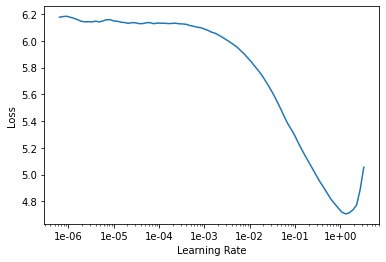

In [74]:
learn.recorder.plot()

In [26]:
learn.freeze()

In [27]:
lr = 1e-2
moms = (0.8,0.7) # what does this mean?
cycles = 25

In [28]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,5.313202,4.541317,0.073186,00:32
1,4.373714,3.242053,0.121749,00:32
2,3.391310,2.654583,0.243680,00:32
3,2.890514,2.425388,0.287751,00:32
4,2.620110,2.281751,0.319685,00:32
5,2.475221,2.178084,0.369768,00:32
6,2.370242,2.084107,0.397489,00:32
7,2.294698,2.026421,0.409459,00:32
8,2.256718,1.984872,0.423619,00:32
9,2.222036,1.964643,0.427860,00:32


In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(cycles, slice((lr/2)/(2.6**4),lr/2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,2.115201,1.876179,0.447879,00:34
1,2.077549,1.844902,0.455873,00:34
2,2.024087,1.797899,0.467494,00:34
3,1.943119,1.734623,0.482771,00:34
4,1.864378,1.663567,0.503557,00:34
5,1.767367,1.593680,0.525809,00:34
6,1.706473,1.565458,0.536523,00:34
7,1.639815,1.501266,0.552093,00:34
8,1.606385,1.477016,0.558845,00:34
9,1.565393,1.449161,0.565332,00:34


In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(cycles, slice((lr/4)/(2.6**4),lr/4), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.399645,1.339334,0.597308,00:41
1,1.398596,1.338232,0.597824,00:41
2,1.409389,1.337974,0.598382,00:41
3,1.400537,1.330533,0.598940,00:41
4,1.383977,1.333545,0.599177,00:41
5,1.367948,1.321229,0.602121,00:41
6,1.369072,1.320448,0.603390,00:41
7,1.350388,1.305448,0.607896,00:41
8,1.350033,1.298592,0.608594,00:41
9,1.339753,1.295022,0.611189,00:41


In [31]:
learn.unfreeze()
learn.fit_one_cycle(cycles, slice((lr/8)/(2.6**4),lr/8), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.264078,1.257512,0.622084,00:45
1,1.272261,1.258413,0.622112,00:45
2,1.277806,1.258510,0.621749,00:45
3,1.280006,1.256268,0.621373,00:45
4,1.283561,1.255611,0.621610,00:45
5,1.272761,1.255105,0.622963,00:45
6,1.270155,1.251277,0.623898,00:45
7,1.270278,1.250451,0.623856,00:45
8,1.254601,1.247346,0.624763,00:45
9,1.256754,1.247303,0.624721,00:45


In [32]:
TEXT = "bob"
N_WORDS = 1000
N_SENTENCES = 1

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

bob i n   d r a g o n xxbos   s h a k e   h o u s e xxbos   c h u t n e y   f o o d   v a l l e y xxbos   m o r a d o ' s   f i s h     a n d     c h i p s xxbos   b u r g e r   k i n g   b a y   f o o d   a n d   g r i l l xxbos   s u b w a y   g r i l l   s t a r xxbos   f o o d   f a t b o o xxbos   p a l m   m o n t e xxbos   t h e   k h y b e r   k i t c h e n xxbos   r o y a l   g r i l l xxbos   p r e p s t o p   f i s h   b a r xxbos   b a n g   a   b a n g l a d e s h i xxbos   t u ' s   b u r g e r s   k i t c h e n xxbos   y u b e   y u m m y xxbos   s h a h   r e s t a u r a n t xxbos   c h a i   c o c k t a i l   b a r xxbos   s u b w a y ( r )   c o r n e r   r o a d xxbos   s p e n d o ' s   l e i s e r r y xxbos   d a   m a s a l a   n a p o l i xxbos   k i n g s   g r i l l xxbos   t h e   g r e e n   c a f e xxbos   j a m o n   c a n t o n e s e   r e s t a u r a n t xxbos   f l a v o u r s   d e s s e r t     a n d     b a r r xxbos   t h e   t r e e   e x p r e s s 

In [34]:
learn.save_encoder('just_eat_enc_bs128_2_11-01-22')

# Classification Models

In [35]:
data = TextClasDataBunch.from_df(path='.', train_df=train_df, valid_df=test_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [36]:
learn_class = text_classifier_learner(data, AWD_LSTM,drop_mult=1.0)

In [37]:
learn_class.load_encoder('just_eat_enc_bs128_2_11-01-22')
learn_class.unfreeze()

In [38]:
lr = 1e-3
moms = (0.7,0.8)
cycles = 25

learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.230729,1.232110,0.629799,00:45
1,1.228706,1.230849,0.630385,00:45
2,1.224511,1.227848,0.630525,00:45
3,1.230300,1.228670,0.630915,00:45
4,1.223256,1.225138,0.631264,00:45
5,1.215176,1.223651,0.631850,00:45
6,1.202418,1.217034,0.633482,00:45
7,1.195533,1.212312,0.635798,00:45
8,1.175839,1.204521,0.638491,00:45
9,1.174622,1.203605,0.639160,00:45


In [39]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.017725,1.192452,0.648521,00:45
1,1.029733,1.191830,0.648842,00:45
2,1.039093,1.189983,0.649121,00:45
3,1.038487,1.191600,0.648814,00:45
4,1.040126,1.193517,0.648926,00:45
5,1.055625,1.193833,0.648577,00:45
6,1.039301,1.192352,0.648577,00:45
7,1.022495,1.195823,0.647949,00:45
8,1.013154,1.200342,0.649316,00:45
9,1.008624,1.197739,0.649819,00:45


In [40]:
learn.save('11_01_2022_fastai')